<img src="images/hs-aalen-logo.png"/>
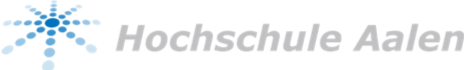

<img src="images/bar.png"/>


# Abschlussbericht Analyseprojekt "Google Reviews Mining"

    Text Mining und Web Analytics 
    Sommersemester 2023
    Christian Wilhelm

Laura Tatlik // Data Science und Business Analytics

<img src="images/Laura.jpg" width="300">

Bastian Rütters // Data Science und Business Analytics

<img src="images/Bastian.jpg" width="300">

Herbi Shtini // Data Science und Business Analytics

<img src="images/Herbi.jpg" width="300">

<img src="images/bar.png">

In [30]:
# NLP-Module
import spacy
from spacy.matcher import Matcher
from spacy.util import minibatch
from spacy.training import Example
from spacy.lang.de.stop_words import STOP_WORDS
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL
from wordcloud import WordCloud
from textblob_de import TextBlobDE as TextBlob

# Module zur Datenbearbeitung und Visualisierung
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Module zur Vorhersagung der neuen Bewertung
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Sontige Module
import numpy as np
import re
import string

In [31]:
nlp = spacy.load('de_core_news_md')
pd.set_option('display.max_colwidth', None)
sns.set_theme()

## Inhaltsverzeichnis

1 Einleitung<br>
2 CRISP-DM<br>
&nbsp;&nbsp;&nbsp;2.1 Business Understanding<br>
&nbsp;&nbsp;&nbsp;2.2 Data Preparation<br>
&nbsp;&nbsp;&nbsp;2.3 Data Understanding<br>
&nbsp;&nbsp;&nbsp;2.4 Modeling<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.1 Vorbereitungen<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.2 NLP-textcat_multilabel<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.3 Bewertung des Modell<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.4 Vorhersage der Bewertung<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.5 Bewertung des Ergebnis<br>
&nbsp;&nbsp;&nbsp;2.5 Evaluation<br>
&nbsp;&nbsp;&nbsp;2.6 Deployment<br>
3 Fazit

## 1 Einleitung

Dieser Bericht dient als Ergänzung zu der schriftlichen Ausarbeitung um vor allem den geschriebenen Code in diesem Projekt gut veranschaulichen zu können.

<img src="images/bar.png">

## 2 CRISP-DM
<img src="images/CRISP-DM_klein.png" width="600">
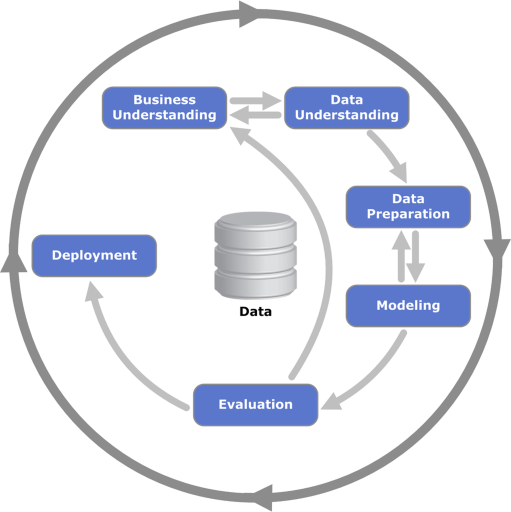

### 2.1 Business Understanding
Nahezu jeder hat sich in Zeiten der Digitalisierung bei der Suche nach einem geeigneten Restaurant oder Lieferdienst, bereits an den Bewertungen im Internet anderer Kunden bedient und anschließend darauf eine Entscheidung für oder gegen eine mögliche Location entschieden. Ob nach der Entscheidung aber genau die eigenen Bedürfnisse entsprechend befriedigt werden, bleibt offen bis zur eigenen Erfahrung. Im folgenden Jupyter Notebook wird die Herangehensweise und Methodik anhand von Code, Codekommentaren und Markdown-Felder erkläutert.

<img src="images/Project_Canvas.jpg" width="1000">

<img src="images/bar.png">

### 2.2 Data Preparation
Die Phase der Datenvorbereitung umfasst alle Aktivitäten zur Erstellung des endgültigen Datensatzes oder der Daten, die aus den anfänglichen Rohdaten in das Modell eingespeist werden. Zu den Aufgaben gehören die Auswahl von Tabellen, Datensätzen und Attributen sowie die Umwandlung und Bereinigung von Daten für das Modell [1].

Die Rohdaten für dieses Projekt werden durch den Scraper (../scrapper/GoogleReviewScrapper.ipynb) von Google Maps extrahiert und als csv-Datei in ../data/reviews.csv gespeichert.

Gescrapt wurden die Bewertungen von 3 Restauraunts/Imbissbuden:

- Super Bros: Pizzaria in Frankfurt am Main
- Dene Gör: Dönerladen in Düsseldorf
- Space Burger: Burgerladen in Düsseldorf

In [32]:
# Einlesen der gescrapten Daten
REVIEWS_FILE_PATH = 'data/reviews_merged.csv'
REVIEWS_CLEANED_FILE_PATH = 'data/reviews_merged_cleaned.csv'
REVIEWS_CLEANED_UNLABELED_FILE_PATH = 'data/reviews_merged_unlabeled_cleaned.csv'

df = pd.read_csv(REVIEWS_FILE_PATH, sep=';')

In [33]:
df.columns = ['caption',
              'food_positive', 'food_negative',
              'service_positive', 'service_negative',
              'ambient_positive', 'ambient_negative',
              'price_positive', 'price_negative',
              'waiting_positive', 'waiting_negative',
              'rating']

In [34]:
df.head(3)

,caption,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative,rating
0,Mega cooles Ambiente und Konzept die Bürger sind auch geschmacklich sehr lecker. Man kann seiner Bürger individuelle auf seine Bedürfnisse anpassen ( Allergien/vegetarisch/Co) …,1,0,0,0,0,0,0,0,0,0,4.0
1,"Super sympathische Mitarbeiter, eine wirklich freundliche und gemütliche Atmosphäre und fantastisches Essen! Wir kommen ganz sicher öfter. …",1,0,1,0,1,0,0,0,0,0,5.0
2,"DAS nenne ich Burger! Nicht so ein Schicki-Micki möchte gerne Burgerladen in Dortmund! *hüstel* Ein absoluter Kult! Maestro del Tozzi - ein Gedicht! Wann immer ich in der Gegend bin, Space Burger oder Lupo. Beides einfach Kult! (Translated by Google) THAT'S what I call burgers! Not such a fancy mic would like a burger shop in Dortmund! *cough* An absolute cult! Maestro del Tozzi - a poem! Whenever I'm in the area, Space Burger or Lupo. Both simply cult!",1,0,0,0,1,0,0,0,0,0,5.0


In [35]:
# Entfernen aller Datenpunkte mit NaN
USEFUL_COLUMNS = ['caption',
                  'food_positive', 'service_positive', 'ambient_positive', 'price_positive', 'waiting_positive', 'rating']
df = df.loc[~df['caption'].isnull(), USEFUL_COLUMNS]

# Indexspalte entfernen
df.reset_index(drop=True)

# Übersicht über bearbeiteten Dataframe
df.head(3)

,caption,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating
0,Mega cooles Ambiente und Konzept die Bürger sind auch geschmacklich sehr lecker. Man kann seiner Bürger individuelle auf seine Bedürfnisse anpassen ( Allergien/vegetarisch/Co) …,1,0,0,0,0,4.0
1,"Super sympathische Mitarbeiter, eine wirklich freundliche und gemütliche Atmosphäre und fantastisches Essen! Wir kommen ganz sicher öfter. …",1,1,1,0,0,5.0
2,"DAS nenne ich Burger! Nicht so ein Schicki-Micki möchte gerne Burgerladen in Dortmund! *hüstel* Ein absoluter Kult! Maestro del Tozzi - ein Gedicht! Wann immer ich in der Gegend bin, Space Burger oder Lupo. Beides einfach Kult! (Translated by Google) THAT'S what I call burgers! Not such a fancy mic would like a burger shop in Dortmund! *cough* An absolute cult! Maestro del Tozzi - a poem! Whenever I'm in the area, Space Burger or Lupo. Both simply cult!",1,0,1,0,0,5.0


In [36]:
# Translated by Google aus den Bewertungen entfernen
df['caption'] = df['caption'].str.split('(Translated by Google)').str[0]

# Übersicht über bearbeiteten Dataframe
df.head(3)

,caption,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating
0,Mega cooles Ambiente und Konzept die Bürger sind auch geschmacklich sehr lecker. Man kann seiner Bürger individuelle auf seine Bedürfnisse anpassen ( Allergien/vegetarisch/Co) …,1,0,0,0,0,4.0
1,"Super sympathische Mitarbeiter, eine wirklich freundliche und gemütliche Atmosphäre und fantastisches Essen! Wir kommen ganz sicher öfter. …",1,1,1,0,0,5.0
2,"DAS nenne ich Burger! Nicht so ein Schicki-Micki möchte gerne Burgerladen in Dortmund! *hüstel* Ein absoluter Kult! Maestro del Tozzi - ein Gedicht! Wann immer ich in der Gegend bin, Space Burger oder Lupo. Beides einfach Kult! (",1,0,1,0,0,5.0


In [37]:
# Übersicht über Stop-Words in der deutschen Sprache
print(STOP_WORDS)

{'dieser', 'da', 'zunächst', 'er', 'manchen', 'manche', 'wenn', 'zur', 'genug', 'hinter', 'manchem', 'sechsten', 'zeit', 'sagt', 'andern', 'dich', 'würden', 'eine', 'einer', 'na', 'derselbe', 'jahren', 'ihre', 'bisher', 'nachdem', 'vierter', 'dass', 'dagegen', 'recht', 'eben', 'solchem', 'eigenen', 'ihnen', 'werde', 'mein', 'unser', 'gewesen', 'vielen', 'irgend', 'eigen', 'los', 'den', 'solche', 'ganzer', 'groß', 'macht', 'neue', 'besonders', 'wollen', 'gemacht', 'mehr', 'während', 'keiner', 'etwas', 'wahr', 'mag', 'als', 'du', 'dritten', 'nun', 'siebente', 'der', 'dahin', 'eigenes', 'muss', 'ganz', 'gross', 'will', 'nicht', 'zweiten', 'gesagt', 'erst', 'geschweige', 'zweite', 'geworden', 'bald', 'ab', 'kann', 'jeden', 'ach', 'dort', 'lang', 'danach', 'wem', 'derselben', 'jahre', 'erste', 'kurz', 'entweder', 'heißt', 'achte', 'wer', 'kleines', 'leider', 'manches', 'durfte', 'nach', 'habe', 'tel', 'achtes', 'wirst', 'dabei', 'dermassen', 'gar', 'hätte', 'jeder', 'noch', 'rechter', 'habt

In [38]:
REGX_USERNAME = r"@[A-Za-z0-9$-_@.&+]+"
REGX_URL = r"https?://[A-Za-z0-9./]+"
def preprocessing(text):
    text = text.lower()

    # Benutzernamen und URLs aus dem Text entfernen
    text = re.sub(REGX_USERNAME, ' ', text)
    text = re.sub(REGX_URL, ' ', text)

    # Emojis durch Text ersetzen
    emojis = {
        ':)': 'positive emotionen',
        ':(': 'negative emotionen'
    }

    for e in emojis:
        text = text.replace(e, emojis[e])
        
    # Tokenisiere den Text mit dem SpaCy-Modell
    tokens = [token.text for token in nlp(text)]

    # Entferne Stoppwörter, Interpunktion und Wörter mit weniger als 3 Zeichen.
    tokens = [t for t in tokens if
              t not in STOP_WORDS and
              t not in string.punctuation and
              len(t) > 3]
    
    # Zahlen aus dem Text entfernen
    tokens = [t for t in tokens if not t.isdigit()]
    
    text = " ".join(tokens);

    # Lemmatisierung
    '''
    allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    lemmatized = " ".join(new_text).lower()
    '''
    return text

In [39]:
# Funktion "preprocessing" auf die Spalte "caption" anwenden und in die neue Spalte "caption_clean" hinzufügen
df["caption_clean"] = df["caption"].apply(preprocessing)

# df Dataframe
USEFUL_COLUMNS_AND_CLEAN = USEFUL_COLUMNS[:]
# Die Spalte 'caption' wird zu diesem Zeitpunkt nicht ausgewählt,
# stattdessen wird 'caption_clean' genommen.
USEFUL_COLUMNS_AND_CLEAN.remove('caption')
USEFUL_COLUMNS_AND_CLEAN.append('caption_clean') # Select caption_clean


df = df[USEFUL_COLUMNS_AND_CLEAN]

# Die Spalte 'caption_clean' jetzt mit 'caption' ersetzen
df = df.rename(columns={"caption_clean": "caption"}) #
USEFUL_COLUMNS_AND_CLEAN.append('caption') # add caption
USEFUL_COLUMNS_AND_CLEAN.remove('caption_clean') # Remove caption_clean
df.reset_index(drop=True)

,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating,caption
0,1,0,0,0,0,4.0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch
1,1,1,1,0,0,5.0,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter
2,1,0,1,0,0,5.0,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult
3,0,0,0,0,0,1.0,gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet
4,1,0,1,0,0,4.0,fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß
...,...,...,...,...,...,...,...
354,1,0,0,0,0,5.0,hervorragende neapolitanische pizza
355,1,1,1,0,1,5.0,staff super fruendliche atmosphäre chillig schöne auswahl pizzas lecker schnell fertig wartezeit qalität leidet
356,1,0,0,0,0,5.0,leckere pizza hochpreisig
357,1,0,0,0,0,5.0,amazing pizza


In [40]:
# Übersicht über bearbeitete Daten
df.head(3)

,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating,caption
0,1,0,0,0,0,4.0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch
1,1,1,1,0,0,5.0,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter
2,1,0,1,0,0,5.0,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult


In [41]:
# Erneutes löschen der NaN Werte in bearbeiteten Spalten
df = df.loc[~df['caption'].isnull(), USEFUL_COLUMNS_AND_CLEAN]
df = df[df['caption'].str.strip().astype(bool)]

In [42]:
# Übersicht über die Spalte mit dem Text
df['caption'].head()

0                                           mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch
1                                                                 super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter
2                    nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult
3                                                gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet
4    fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß
Name: caption, dtype: object

In [43]:
# Dataframe als csv-Datei abspeichern
df[['caption', 'rating']].to_csv(REVIEWS_CLEANED_UNLABELED_FILE_PATH, sep=';')
df.to_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

<img src="images/bar.png">

### 2.3 Data Understanding
Die zweite Phase im CIRSP-DM Model, das Data Understanding, ist der Schritt, in dem man Daten aus verschiedenen Quellen sammelt, aufbereitet, untersucht, relevante Daten für die Analyse auswählt, Datenziele anpasst, mögliche Datenprobleme identifiziert und ein besseres Verständnis der Daten erhält, um fundierte Entscheidungen für die weitere Analyse treffen zu können [1].

In [44]:
# Relativen Pfad definieren
REVIEWS_CLEANED_FILE_PATH = 'data/reviews_merged_cleaned.csv'

# Einlesen der bearbeiteten Daten
df = pd.read_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

In [45]:
# Alle Bewertungen in einen langen String joinen
full_caption_text = '. '.join(df['caption'])
len(full_caption_text)

24746

In [46]:
# Funktion um die meist genutzten Wörter zu ermitteln
def getWordFrequency(text, pos="NOUN", top_items=0):
    doc = nlp(text)
    words = [token.lemma_
             for token in doc
             if (not token.is_stop and not token.is_punct and (pos == "" or token.pos_ == pos))]
    word_freq = Counter(words)

    return(dict(word_freq.most_common(top_items) if top_items else word_freq.most_common()))

#### 2.3.1 Anzahl der Google-Bewertungen pro Bewertungsgruppe

[Text(0.5, 0, 'Bewertung'), Text(0, 0.5, 'Zahl')]

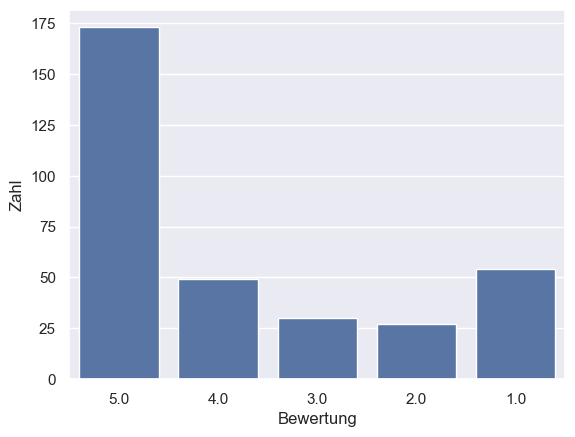

In [47]:
# Axen initialisieren
f, ax = plt.subplots(1,1)
# Ermitteln der Anzahl der Sterne-Bewertungen
ratings = df['rating'].value_counts().reset_index()
# Spalten definieren
ratings.columns = ['rating', 'count']
# Abstiegend sortieren
ratings = ratings.sort_values(by=['rating'], ascending=False)
# Barplot erstellen
sns.barplot(data=ratings, x="rating", y='count', color='b', ax=ax, order=ratings['rating'])
ax.set(xlabel='Bewertung', ylabel='Zahl')

####  2.3.2 Meistverwendete Wörter

In [48]:
# Funktionszuweisung - freq
freq = getWordFrequency(full_caption_text, "NOUN")

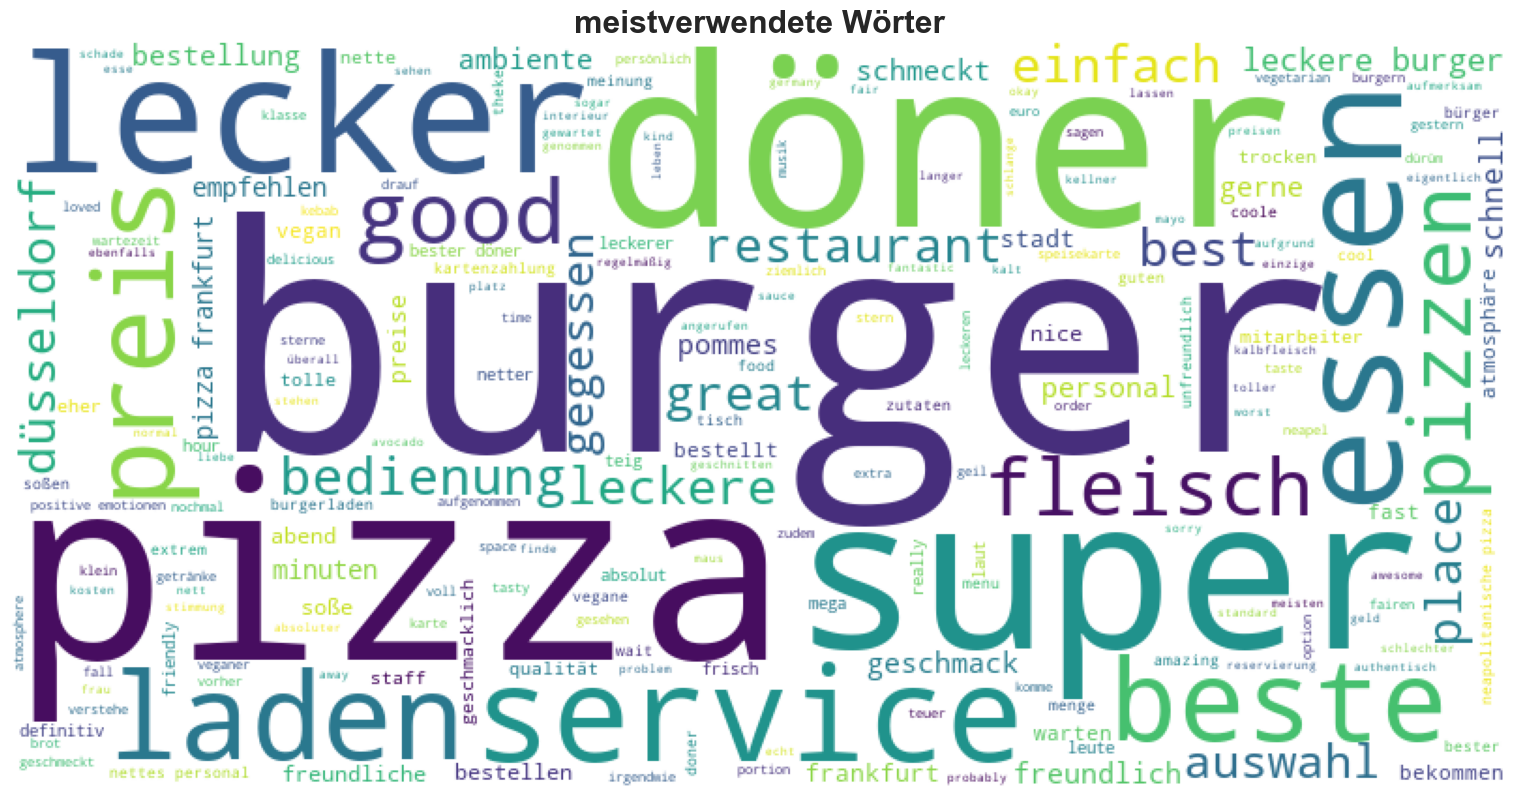

In [49]:
# WordCloud-Diagramm der am häufigsten verwendeten Wörter erstellen
plt.figure(figsize=(15, 12), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 400,
                     background_color='white').generate( full_caption_text ))
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('meistverwendete Wörter', fontsize=23, fontweight='bold')
plt.show()

#### 2.3.4 Meistverwendete Nomen & Verben

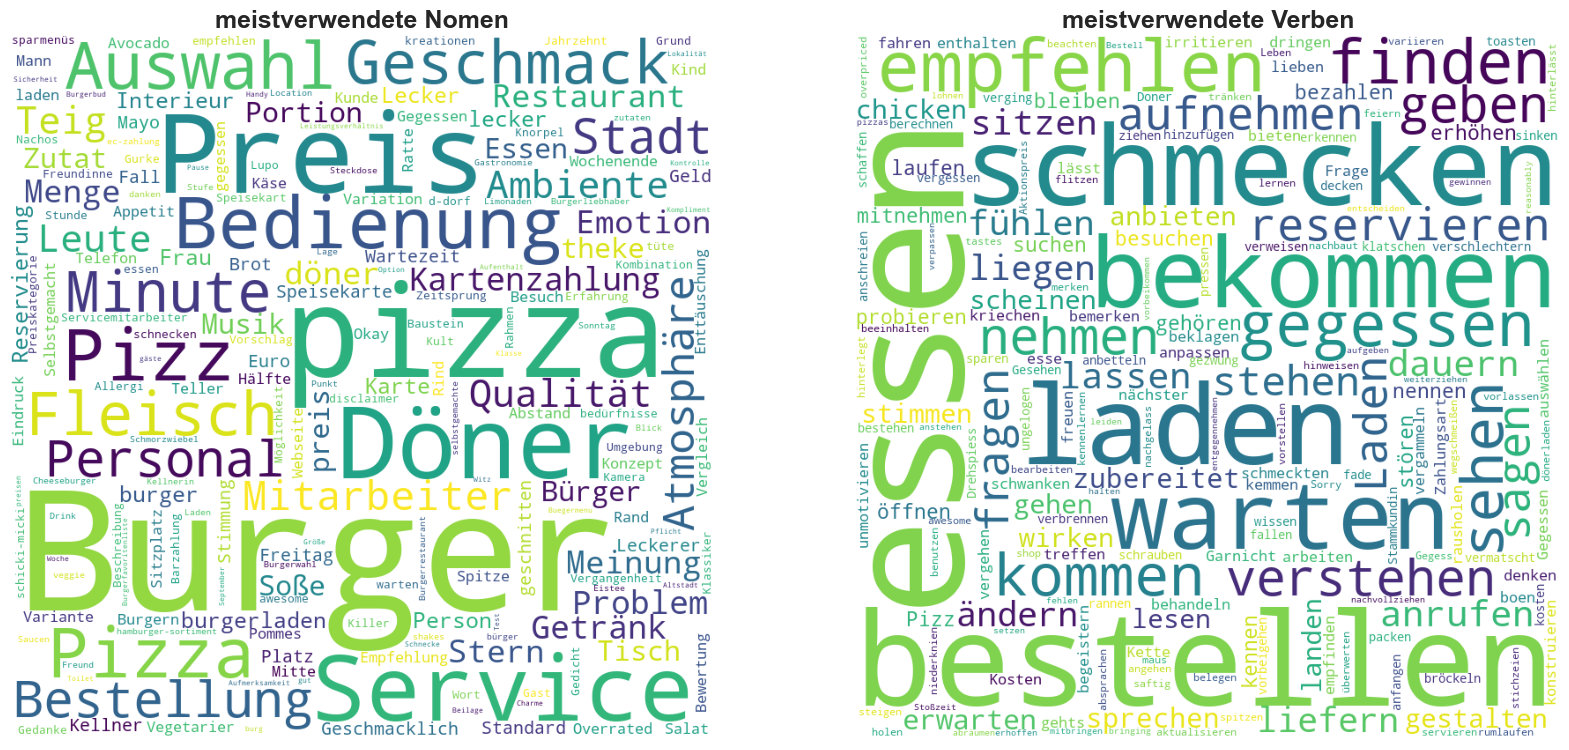

In [50]:
# Erstellung meistverwendeten Nomen und Verben
freqNoun = getWordFrequency(full_caption_text, "NOUN")
freqVerb = getWordFrequency(full_caption_text, "VERB")

# Erstellung der Variablen "freqs" und "titles", um die Häufigkeit von Nomen und Verben darzustellen.
freqs = [freqNoun, freqVerb]
titles = ['meistverwendete Nomen', 'meistverwendete Verben']

# WordCloud-Diagramm mit 2 Subplots
f, axes = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(20)
for i, ax in enumerate(axes):
    ax.imshow(WordCloud(width = 800, height = 800,
                        background_color='white').generate_from_frequencies( freqs[i] ))
    ax.axis('off')
    ax.set_title(titles[i], fontsize=18, fontweight='bold')

#### 2.3.5 Meisteverwendete Verben pro Bewertung

In [51]:
# Bewertungen der jeweiligen Sterne-Kategorien in String-Format joinen
full_caption_text_1 = '. '.join(df.loc[df['rating'] == 1]['caption'])
full_caption_text_2 = '. '.join(df.loc[df['rating'] == 2]['caption'])
full_caption_text_3 = '. '.join(df.loc[df['rating'] == 3]['caption'])
full_caption_text_4 = '. '.join(df.loc[df['rating'] == 4]['caption'])
full_caption_text_5 = '. '.join(df.loc[df['rating'] == 5]['caption'])

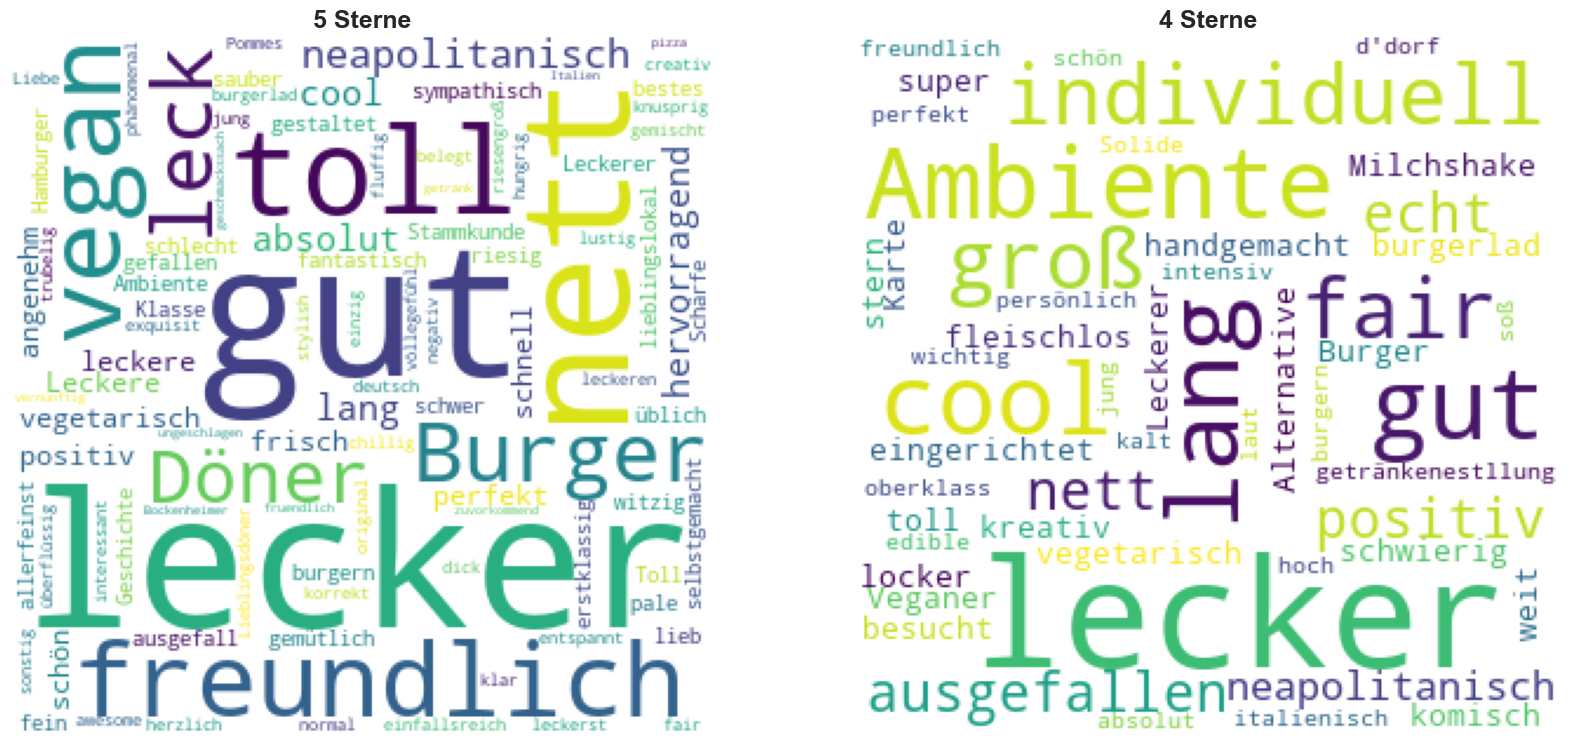

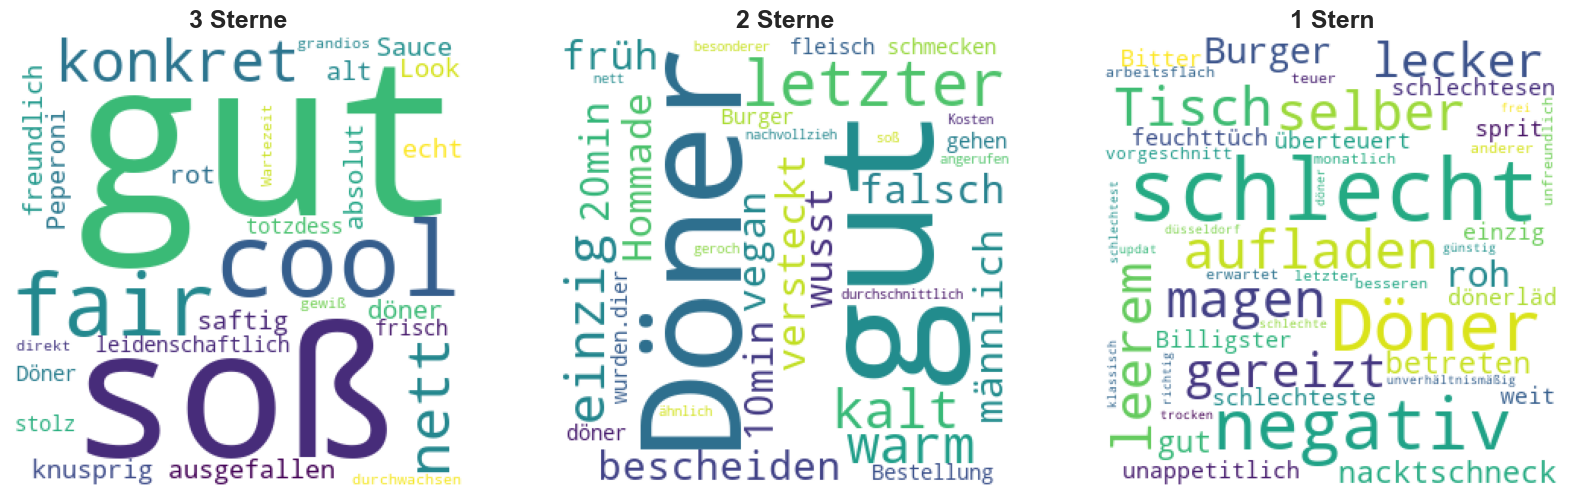

In [52]:
# Berechnung der Häufigkeit von Adjektiven im Text mit 5 und 4 Sternen Bewertung
freqs1 = [ getWordFrequency(full_caption_text_5, "ADJ"),
           getWordFrequency(full_caption_text_4, "ADJ")]

# Berechnung der Häufigkeit von Adjektiven im Text mit 3, 2 und 1 Sternen Bewertung
freqs2 = [getWordFrequency(full_caption_text_3, "ADJ"),
          getWordFrequency(full_caption_text_2, "ADJ"),
          getWordFrequency(full_caption_text_1, "ADJ")]

# Titel für das Wordcloud-Diagramm
titles1 = ['5 Sterne', '4 Sterne']
titles2 = ['3 Sterne', '2 Sterne', '1 Stern']

# Erstellung von zwei Subplots mit einer Spalte und zwei bzw. drei Zeilen.
f1, axes1 = plt.subplots(1, 2)
f2, axes2 = plt.subplots(1, 3)

# Plotgröße ändern
f1.set_figheight(15)
f1.set_figwidth(20)

# Plotgröße ändern
f2.set_figheight(15)
f2.set_figwidth(20)

# Erstellung der WordCloud-Diagramme für Texte mit 5 und 4 Sterne Bewertung
for i, ax in enumerate(axes1):
    ax.imshow(WordCloud(width = 300, height = 300,
                        background_color='white').generate_from_frequencies( freqs1[i] ))
    ax.axis('off')
    ax.set_title(titles1[i], fontsize=18, fontweight='bold')

# Erstellung der WordCloud-Diagramme für Texte mit 3, 2 und 1 Sterne Bewertung
for i, ax in enumerate(axes2):
    ax.imshow(WordCloud(width = 300, height = 300,
                        background_color='white').generate_from_frequencies( freqs2[i] ))
    ax.axis('off')
    ax.set_title(titles2[i], fontsize=18, fontweight='bold')

<img src="images/bar.png">

### Labeling

In [53]:
df = pd.read_csv(REVIEWS_CLEANED_UNLABELED_FILE_PATH, sep=';')
df.head()

,Unnamed: 0,caption,rating
0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0
1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0
2,2,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult,5.0
3,3,gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet,1.0
4,4,fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß,4.0


In [54]:
categories = ['essen', 'service', 'atmosphäre', 'preis', 'warten']
categories_columns = ['food_positive', 'food_negative',
                      'service_positive', 'service_negative',
                      'ambient_positive', 'ambient_negative',
                      'price_positive', 'price_negative',
                      'waiting_positive', 'waiting_negative']

In [55]:
def spacy_most_similar(word, topn=10):
    ms = nlp.vocab.vectors.most_similar(
        nlp(word).vector.reshape(1,nlp(word).vector.shape[0]), n=topn)
    words = [nlp.vocab.strings[w] for w in ms[0][0]]
    distances = ms[2]
    return words, distances

In [56]:
spacy_most_similar(categories[0])

(['Aufessen',
  'weggefuttert',
  'drinken',
  'einzukochen',
  'koten',
  'inhaliere',
  'knabbere',
  'Bio-Essen',
  'schmatz',
  'Trinket'],
 array([[1.    , 0.8243, 0.8131, 0.7734, 0.7115, 0.7059, 0.7032, 0.6845,
         0.672 , 0.6681]], dtype=float32))

#### Aspect based sentiment analysis

In [57]:
matcher = Matcher(nlp.vocab)
patterns = [
    [{'POS':'ADJ', 'OP': '+'}, {'POS':'NOUN'}],
    [{'POS':'NOUN'}, {'POS':'VERB'}, {'POS':'ADJ'}]
]
matcher.add("category", patterns)

df_matches = pd.DataFrame([], columns=['index', 'aspect', 'entity_group'])

similarity_min = 0.4

for rowIndex, wordText in enumerate(df['caption']):
    doc = nlp(wordText)
    matches = matcher(doc)

    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        span = doc[start:end]

        for i, s in enumerate(span):
            if s.pos_ in ['NOUN']:
                category = ''
                similarity = 0

                similarity_cat0 = nlp(categories[0]).similarity(span)
                if similarity_cat0 > similarity_min: # fits into
                    category = categories[0]
                    similarity = similarity_cat0

                print(span)
                similarity_cat1 = nlp(categories[1]).similarity(span)
                if similarity_cat1 > similarity_min: # fits into
                    category = categories[1]
                    similarity = similarity_cat1

                similarity_cat2 = nlp(categories[2]).similarity(span)
                if similarity_cat2 > similarity_min: # fits into
                    category = categories[2]
                    similarity = similarity_cat2

                similarity_cat3 = nlp(categories[3]).similarity(span)
                if similarity_cat3 > similarity_min: # fits into
                    category = categories[3]
                    similarity = similarity_cat3

                similarity_cat4 = nlp(categories[4]).similarity(span)
                if similarity_cat4 > similarity_min: # fits into
                    category = categories[4]
                    similarity = similarity_cat4

                df_matches = pd.concat([pd.DataFrame({'index': rowIndex,
                                                      'aspect': category,
                                                      'entity_group': span.text,
                                                      }, columns=df_matches.columns, index=[0]),
                                        df_matches])

ambiente konzept
cooles ambiente konzept
lecker bürger
individuelle bedürfnisse
sympathische mitarbeiter
gemütliche atmosphäre
freundliche gemütliche atmosphäre
fantastisches essen
burger schicki-micki
absoluter kult
burger lupo
selben burger
individuelle möglichkeiten
ambiente zeitsprung
alternativen ambiente zeitsprung
fleischlose alternativen ambiente zeitsprung
bester service
lecker burger
fairen preis
ambiente kartenzahlung
coolen ambiente kartenzahlung
leckere burger
freundliche bedienung
klasse auswahl
milchshake kombination
sterne milchshake kombination
veganer vegetarier
bescheidenen services
kreative auswahl
schlechten erfahrungen
tolle atmosphäre
leckere burger
leckere burger
nette bedienung
burger d-dorf
handgemachte burger
lecker gast
tische minuten
kalter burger
nettes personal
erstklassige burger
witziges ambiente
lieblingslokale stadt
eingerichtetes restaurant
lockeren servicemitarbeitern
größer sparmenüs
versteckte kamera
cooles ambiente
fairen preisen
bester burger
ba

/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:25: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat0 = nlp(categories[0]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:31: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat1 = nlp(categories[1]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:36: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat2 = nlp(categories[2]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:41: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat3 = nlp(categories[3]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:46: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarit

dönerläden stadt
schlechte qualität
schlechteste döner
peperoni döner
beste peperoni döner
döner preis
einziger stern
döner schmeckt absoluter
absoluter standard
appetit gesehen anderer
anderer zutaten
negative emotionen
qualität verschlechtert rote
soße geschmack
rote soße geschmack
restaurant gerannt letztes
letztes döner
negativen sinne
unfreundliche bedienung
soße ertränkt
monatlichen preiserhöhungen
look kind
erwartete döner
teurer preis
besseren döner
unverhältnismäßiger preisanstieg
döner plastik
durchschnittlicher standard
günstigste preis
besonderes fett
leidenschaftlicher essenkritiker
totzdessen gemüse
döner totzdessen gemüse
soße brot
richtiges fleisch
schlechte qualität
döner stadt
beste döner stadt
soße soße
ähnlichem sterne
netten mitarbeiter
letzter gefühl
düsseldorfer innenstadt
bessere gegessen
update chance
lustiges personal
herzliches lustiges personal
lieblingsdöner herzliches lustiges personal
absoluter lieblingsdöner herzliches lustiges personal
bester döner
döne

/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:25: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat0 = nlp(categories[0]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:31: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat1 = nlp(categories[1]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:36: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat2 = nlp(categories[2]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:41: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_cat3 = nlp(categories[3]).similarity(span)
/var/folders/8f/b5rl_hw50bn0_k4xrt7mtm7w0000gn/T/ipykernel_93336/2380499998.py:46: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarit

leckere pizza
vegane käse
lecker vegane käse
pizza essen getränke
getränke theke
pizza niveau
zuvorkommendes personal
freundliches zuvorkommendes personal
schönen abend
neapolitanische pizza
vernünftige neapolitanische pizza
beste pizza
italiens stimmung
geschmackssache pizza
nettes personal
angenehmes ambiente
neapolitanische pizza
hervorragende neapolitanische pizza
fruendliche atmosphäre
schöne auswahl
leckere pizza
jüngere volk


In [58]:
df_matches

,index,aspect,entity_group
0,332,,jüngere volk
0,330,essen,leckere pizza
0,329,,schöne auswahl
0,329,atmosphäre,fruendliche atmosphäre
0,328,,hervorragende neapolitanische pizza
...,...,...,...
0,1,atmosphäre,sympathische mitarbeiter
0,0,,individuelle bedürfnisse
0,0,essen,lecker bürger
0,0,atmosphäre,cooles ambiente konzept


#### TextBlob sentiment analysis

In [59]:
sentiment_polarities = []
sentiment_subjectivities = []

for i, row in df_matches.iterrows():
    sentiment = TextBlob(row['entity_group']).sentiment
    sentiment_polarities.append(sentiment.polarity)
    sentiment_subjectivities.append(sentiment.subjectivity)

df_matches['sentiment_polarity'] = sentiment_polarities
df_matches['sentiment_subjectivity'] = sentiment_subjectivities

df_matches_sorted = df_matches.sort_values(by='index')
print(df_matches_sorted)

   index      aspect                         entity_group  sentiment_polarity  \
0      0  atmosphäre                     ambiente konzept                 0.0   
0      0                         individuelle bedürfnisse                 0.0   
0      0  atmosphäre              cooles ambiente konzept                 0.7   
0      0       essen                        lecker bürger                 0.0   
0      1       essen                  fantastisches essen                 1.0   
..   ...         ...                                  ...                 ...   
0    328              hervorragende neapolitanische pizza                 1.0   
0    329  atmosphäre               fruendliche atmosphäre                 0.0   
0    329                                   schöne auswahl                 1.0   
0    330       essen                        leckere pizza                 0.0   
0    332                                     jüngere volk                 0.0   

    sentiment_subjectivity 

In [60]:
df.head(3)

,Unnamed: 0,caption,rating
0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0
1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0
2,2,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult,5.0


In [61]:
# Loop through all df_matches
# For each index check the aspect, if it matches a category
# Update the right category of df with the respective sentiment
for column in categories_columns:
    df[column] = 0

for rowIndex, row in df.iterrows():
    entities_by_index = df_matches_sorted.loc[df_matches_sorted['index'] == rowIndex]
    # reset
    for j, item in entities_by_index.iterrows():
        if item['aspect'] != '':
            category_i = categories.index(item['aspect'])
            polarity = item['sentiment_polarity']
            if polarity != 0:
                column_index = (category_i * 2) if polarity > 0 else (category_i * 2) + 1
                df.at[rowIndex, categories_columns[column_index]] = 1

df.head()

,Unnamed: 0,caption,rating,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative
0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0,0,0,0,0,1,0,0,0,0,0
1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0,1,0,0,0,1,0,0,0,0,0
2,2,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult,5.0,0,0,0,0,0,0,0,0,0,0
3,3,gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet,1.0,0,0,0,0,0,0,0,0,0,0
4,4,fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß,4.0,0,0,0,0,0,0,0,0,0,0


In [62]:
df.to_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

<img src="images/bar.png">

### 2.4 Modeling
In der vierten Phase des CRISP-DM Modell, dem Modeling, werden verschiedene Modellierungstechniken evaluiert. Es wird überprüft, welche Technik für das jeweilige Data-Mining-Problem am besten anwendbar ist. Hier müssen gegebenenfalls die Schritte der Datenvorbereitung wiederholt werden. Neben der Auswahl der Modellierungstechnik und der eigentlichen Modellierung wird oder werden die Modelle am Ende dieser Phase ebenfalls nach verschiedenen Kriterien bewertet und in den Kontext des Data-Mining-Problems eingeordnet [1].

Für die spätere Bewertung werden bei Klassifizierungsproblemen, wie dies, welches in diesem Projekt vorliegt, Fehlerraten als Qualitätsmaßstab genutzt. Um eine verzerrungsfreie Evaluierung sicherstellen zu können, müssen die Daten in ein Trainings- und einem Testdatensatz getrennt werden. Die Modellierung beruht dann auf dem Trainingsdatensatz und wird mithilfe des Testdatensatzes die Qualität der Vorhersage geschätzt [1].

#### 2.4.1 NLP-TfidfVectorizer

In [63]:
# Selbsterstellte Bewertungen mit Label
trainingsdata = pd.read_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

Die gesäuberten Daten wurden manuell mit den verschiedenen Kategorien gelabelt.

In [64]:
# Übersicht über die Daten
trainingsdata.iloc[:,1:].head()

,Unnamed: 0,caption,rating,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative
0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0,0,0,0,0,1,0,0,0,0,0
1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0,1,0,0,0,1,0,0,0,0,0
2,2,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult,5.0,0,0,0,0,0,0,0,0,0,0
3,3,gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet,1.0,0,0,0,0,0,0,0,0,0,0
4,4,fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß,4.0,0,0,0,0,0,0,0,0,0,0


In [65]:
# Funktion zum Trainieren und Anwenden des Textklassifikationsmodells definieren
def nlp_tfidfvectorizer(data, category, text):
    
    # Ausschnitt der Spalte "caption" und Funktions-Parameter
    subset_train = data[['caption', category]]
    # Ausschnitt in eine Liste von Tuples konventieren
    train_data = list(subset_train.itertuples(index=False, name=None))
    
    # Trainingsdaten (Beispiele von Texten, die manuell in die verschiedenen Kategorien eingeteilt wurden)
    training_data = trainingsdata
    
    # Pipeline, die aus einem TfidfVectorizer und einem LinearSVC-Modell besteht
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svc', LinearSVC())
    ])

    # Modell auf den Trainingsdaten trainieren
    model.fit([text for text, category in training_data], [category for text, category in training_data])

    # Vorhersage der Kategorie
    predicted_category = model.predict([text])
    
    return predicted_category[0] if predicted_category else 0

In obiger Funktion wird eine Pipeline erstellt, die einen Text in ein maschinenlesbares Format umwandelt und dann eine lineare SVM verwendet, um die Textdaten zu klassifizieren. Die Intention dieser Funktion ist eine automatische Zuordnung von Texten zu bestimmten Kategorien auf der Grundlage eines trainierten Modells.

In [66]:
# Vorhersagen für die Kategorie Essen
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Das Essen war gut')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es hat nicht geschmeckt')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Schlechtes Essen')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es war köstlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es war schlimm')}")
print("...")

print(f"\nAccuracy: {3/5}%, jedoch Tendenz zur Vorhersage der Kategorie 1, da Overfitting der Trainingsdaten\nEbenso wurden keine komplexen Satzstellung als Input verwendet")

ValueError: too many values to unpack (expected 2)

In [ ]:
# Vorhersagen für die Kategorie Service
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Super freundlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Unfreundliche Bedienung')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Die Bedienung war sehr unfreundlich')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Die Bedienung war sehr freundlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Das Essen war sehr lecker, doch die Bedienung war nicht freundlich')}")
print("...")

print(f"\nAccuracy: {4/5}%, jedoch nicht Aussagekräftig, da keine komplexen Satzstellungen als Input verwendet wurden")

In [ ]:
# Vorhersagen für die Kategorie Ambiente
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Schönes Ambiente')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Kein schönes Ambiente')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Das Ambiente war schön')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Wir haben uns sehr wohl gefühlt')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Das Essen war sehr lecker, doch das Ambiente war nicht schön')}")
print("...")

print(f"\nAccuracy: {2/5}%, Anwendung komplexerer Satzstellungen --> Resultiert in schlechterer Genauigkeit")

Es ist festzustellen, dass der Umfang des Trainingsdatensatzes zu gering ist um eine gute Vorhersage eines Textes zu erzeugen. Die Vorhersagen in den Unterschiedlichen Kategorien sind vielversprechend, wenn der Text aus wenigen Wörtern besteht und nicht Teil eines komplexen Satzes ist. Aufgrund dessen wird dieser Ansatz verworfen und im nächsten Abschnitt ein Model implementiert, welches die Bewertungen selbst labeln kann. 

#### 2.4.2 Vorbereitungen NLP-textcat_multilabel

In [ ]:
df = pd.read_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')
df.head()

In [ ]:
for _, row in df.iterrows():
    text = row["caption"]
    rating = row["rating"]

    target_columns = ['1', '2', '3', '4', '5']

    doc = nlp(text)

    for column in target_columns:
        doc.cats[column] = (rating == int(column))

In [ ]:
textcat_multilabel = nlp.add_pipe("textcat_multilabel", config={
    "threshold": 0.5,
    "model": DEFAULT_MULTI_TEXTCAT_MODEL,
}, last=True)

# alle 5 Labels hinzufügen
for column in target_columns:
    textcat_multilabel.add_label(column)

In [ ]:
df['rating'].head()

In [ ]:
def load_data(split=0.8):
    split = int(len(df) * split)

    X_train = df['caption'][:split]
    y_train = df['rating'][:split]

    X_test = df['caption'][split:]
    y_test = df['rating'][split:]

    return (X_train, y_train), (X_test, y_test)

In [ ]:
# Train und Test Daten aufteilen
(X_train, y_train), (X_test, y_test) = load_data()

train_data = list(zip(X_train, [{'cats': {
    column: (int(column) == int(rating)) for column in target_columns
}
} for index, rating in enumerate(y_train)]))
#
test_data = list(zip(X_test, [{'cats': {
    column: int(column) == int(rating) for column in target_columns
}
} for index, rating in enumerate(y_test)]))

In [ ]:
train_data[:2]

#### 2.4.3 NLP-textcat_multilabel

In [ ]:
# TextCategorizer trainieren
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat_multilabel']

with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.initialize()
    # Die Gewichte werden 100 Iterationen lang ständig aktualisiert.
    for i in range(100): # Iterations
        losses = {}
        np.random.shuffle(train_data)
        for batch in minibatch(train_data, size=8):
            for text, annotations in batch:
                # Example erstellen
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Das Modell aktualisieren
                nlp.update([example], drop=0.3, sgd=optimizer, losses=losses)

#### 2.4.4 Bewertung des Models


In [ ]:
# Die Bewertung des Models
correct = 0
total = 0
accuracies = []

for index, row in enumerate(test_data):
    text = row[0]
    annotations = row[1]

    doc = nlp(text)
    scores = textcat_multilabel.predict([doc])

    item_accuracies = []
    for i, key in enumerate(target_columns):
        isSame = annotations['cats'][key] == round(scores[0][i])
        item_accuracies.append(1 if isSame else 0)

    score_item_accuracy = np.array(item_accuracies).sum() / len(target_columns)
    accuracies.append(score_item_accuracy)

accuracy = np.array(accuracies).sum() / len(accuracies)
print(f"Genauigkeit: {round(accuracy * 100, 2)}%")

In [ ]:
text = 'Die Staff sind super fruendliche und die Atmosphäre ist chillig. Es gibt eine Schöne Auswahl an Pizzas, die richtig lecker sind. Alles wird schnell fertig gemacht, ohne lange Wartezeit und ohne das die Qalität leidet.'
prediction = textcat_multilabel.predict([nlp(text)])
df_prediction = pd.DataFrame(prediction)
df_prediction.columns = [1, 2, 3, 4, 5]
df_prediction

#### 2.4.5 Vorhersage der Bewertung
Nachdem die gescrapten Bewertungen mithilfe des Models gelabelt wurden, dienen diese Daten nun als Trainingsdaten für eine multiple lineare Regression.

Zur Vorhersage wird dann der Input ....

#### Multiple lineare Regression

In [ ]:
# Dataframe der maschinell gelabelten Daten einlesen
labeld_data = pd.read_csv() # Gelabelte Daten von Textcat Modell

In [ ]:
# Benötigte Spalte definieren --- noch benötigt?
data_predict = labeld_data.iloc[:, 2:]

In [ ]:
# Prädiktoren und Zielvariable definieren
X = data_predict.iloc[:, :-1]
y = data_predict.iloc[:, -1:]

In [ ]:
# NaN-Werte mit 0 füllen
X.fillna(0, inplace=True)

In [ ]:
# Datensatz in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [ ]:
# Lineare Regressionsmodell initialisieren
model = LinearRegression()

In [ ]:
# Model auf die Trainingsdaten fitten
model.fit(X_train, y_train)

In [ ]:
# Vorhersagen treffen
predicitions = model.predict(X_test)

In [ ]:
# Evaluation des Modells

In [ ]:
# Eingabe der gewünschten Kategorien und Vorhersage der neuen Bewertung
neue_bewertung = model.predict(np.array([]).reshape(1, -1)) # Array mit 1/0 je Kategorie übergeben

In [ ]:
# Neue Bewertung gemäß der gewünschten Kriterien
print(round(neue_bewertung[0][0], 2))

#### Random Forest Regression

In [ ]:
# Erstellen des RandomForest-Regression-Modells mit 100 Bäumen
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Anpassen des Modells an die Trainingsdaten
rf.fit(X_train, y_train)

In [ ]:
# Vorhersagen auf den Testdaten durchführen
y_pred = rf.predict(X_test)

In [ ]:
# Berechnen der mittleren quadratischen Abweichung (MSE) des Modells
mse = mean_squared_error(y_test, y_pred)

In [ ]:
# Ausgabe des MSE des Modells
print("MSE:", mse)

In [ ]:
# Vorhersage
vorhersage = rf.predict([]) # Hier Array

# Ausgabe der Vorhersage
print("Vorhersage:", vorhersage)

#### 2.4.5 Bewertung der Ergebnis


<img src="images/bar.png">

### 2.5 Evaluation
Bei der Phase der Evaluation wird überprüft, ob die Zielsetzung des Data-Mining-Projekts erreicht wurde. Hierbei werden die Resultate der Modellierung und das Vorgehen bzw. der Prozess der Informationsgewinnung bewertet. Falls das Ergebnis hier deutlich negativ ausfällt, ist zu überprüfen, ob es gegebenenfalls einen erneuten Durchlauf des CRISP-DM-Modells benötigt. Zum Schluss werden die nächsten Schritte bzw. die Schritte für as Deployment festgelegt [1].

HIER EVALUATION ÜBER MODELL

<img src="images/bar.png">

### 2.6 Deployment

<img src="images/bar.png">

## 3 Fazit

<img src="images/bar.png">

## 4 Quellen

[1] Shearer, C. (2000) The CRISP-DM Model: The New Blueprint for Data Mining. Journal of Data Warehousing, 5, 17.
[2] Marangon, J. (2022, 7. November), Building a Text Classification model with spaCy 3.x. Medium. Online-Vorveröffentlichung. https://medium.com/@johnidouglasmarangon/building-a-text-classification-model-with-spacy-3-x-57e59fa50547
[3] Mattingly, W. (2022), Topic Modeling: Concepts and Theory. Python Humanities. Online-Vorveröffentlichung. http://python-textbook.pythonhumanities.com/04_topic_modeling/04_01_01_intro.html
[4] Pattakos, A. (2021, 28. Februar), Aspect-Based Sentiment Analysis Using Spacy & TextBlob. Towards Data Science. Online-Vorveröffentlichung. https://towardsdatascience.com/aspect-based-sentiment-analysis-using-spacy-textblob-4c8de3e0d2b9
